In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_score,
    precision_recall_curve
)


In [3]:
## read and get info from dataset
df = pd.read_csv('Airline_Delay_Cause.csv')
# Display the first five rows of the DataFrame to get a quick look at the data
print(df.head())
# Show information about the DataFrame: number of entries, column names, data types, and missing values per column
print(df.info())
# Output descriptive statistics for all columns, including both numerical and non-numerical data
print(df.describe(include="all"))
# Print the number of missing (null) values in each column
print("\nNull Count: ")
print(df.isnull().sum())


   year  month carrier       carrier_name airport  arr_flights  arr_del15  \
0  2023      8      9E  Endeavor Air Inc.     ABE         89.0       13.0   
1  2023      8      9E  Endeavor Air Inc.     ABY         62.0       10.0   
2  2023      8      9E  Endeavor Air Inc.     AEX         62.0       10.0   
3  2023      8      9E  Endeavor Air Inc.     AGS         66.0       12.0   
4  2023      8      9E  Endeavor Air Inc.     ALB         92.0       22.0   

   carrier_ct  weather_ct  nas_ct  security_ct  late_aircraft_ct  \
0        2.25        1.60    3.16          0.0              5.99   
1        1.97        0.04    0.57          0.0              7.42   
2        2.73        1.18    1.80          0.0              4.28   
3        3.69        2.27    4.47          0.0              1.57   
4        7.76        0.00    2.96          0.0             11.28   

   arr_cancelled  arr_diverted  arr_delay  carrier_delay  weather_delay  \
0            2.0           1.0     1375.0           7

In [4]:
# Keep only rows where we can compute the delay rate
df = df.dropna(subset=["arr_flights", "arr_del15"])

# Compute delay rate per (year, month, carrier, airport) row
df["arr_delay_rate"] = df["arr_del15"] / df["arr_flights"]

# Create binary label: HighDelay (1) vs LowDelay (0)
# Example threshold: 20% of arrivals delayed ≥ 15 minutes
threshold = 0.20
df["delay_15_label"] = (df["arr_delay_rate"] >= threshold).astype(int)

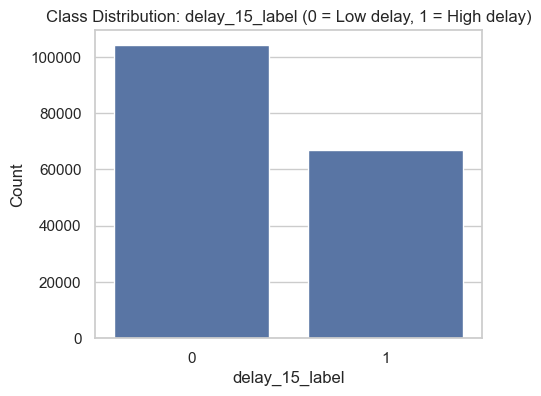

In [ ]:
## Distribution of Low vs high delay classification of delay rates

sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
sns.countplot(x="delay_15_label", data=df)
plt.title("Class Distribution: delay_15_label (0 = Low delay, 1 = High delay)")
plt.xlabel("delay_15_label")
plt.ylabel("Count")
plt.show()


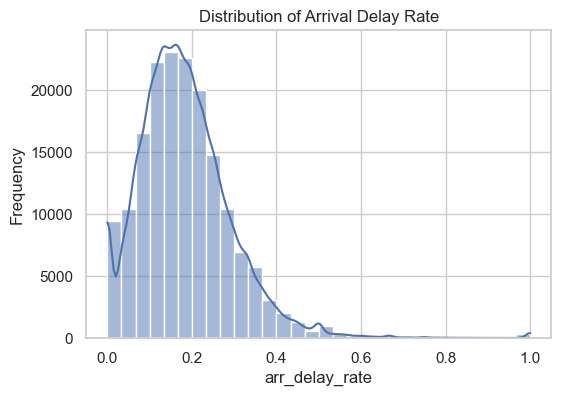

In [6]:
## distribution of delay rates
plt.figure(figsize=(6, 4))
sns.histplot(df["arr_delay_rate"], bins=30, kde=True)
plt.title("Distribution of Arrival Delay Rate")
plt.xlabel("arr_delay_rate")
plt.ylabel("Frequency")
plt.show()


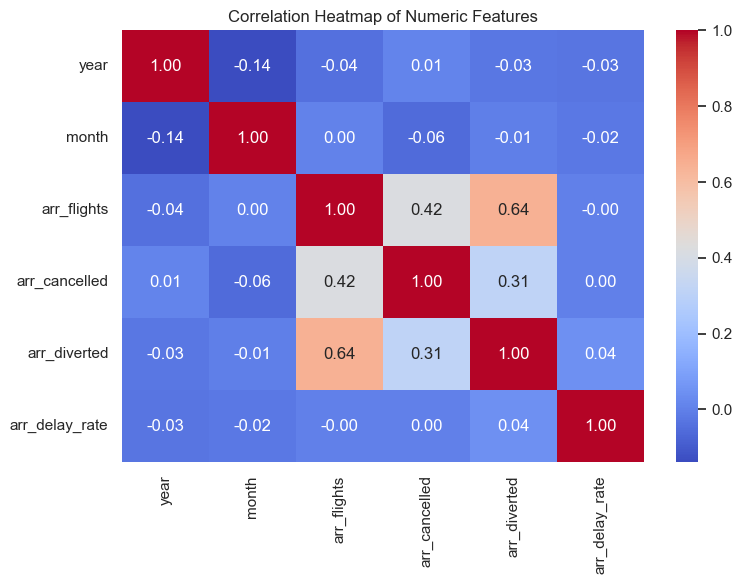

In [7]:
# Select the numeric columns to include in the correlation analysis
numeric_cols = ["year", "month", "arr_flights", "arr_cancelled", "arr_diverted", "arr_delay_rate"]
# Compute the correlation matrix for the selected numeric columns
corr = df[numeric_cols].corr()

# Create Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


In [ ]:
# Features to KEEP (no leakage based off correlation scores)
feature_cols_num = ["year", "month", "arr_flights", "arr_cancelled", "arr_diverted"]
feature_cols_cat = ["carrier", "carrier_name", "airport"]

# Build X and y
X = df[feature_cols_num + feature_cols_cat]
y = df["delay_15_label"]


In [9]:
# Train/test split (same for both models)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Preprocessing: scale numeric, one-hot encode categorical and transform together back 
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore") # Ignore all unknown entries

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat),
    ]
)


In [10]:
# Define Linear SVC 
svc = LinearSVC(
    class_weight="balanced",# to hepp with imbalanced classes
    max_iter=1000
)

# Full SVC pipeline
svc_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("svc", svc),
])

# Fit SVC
svc_clf.fit(X_train, y_train)

# Evaluate SVC
y_pred_svc = svc_clf.predict(X_test)
print("Linear SVC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svc))
print("\nLinear SVC Classification Report:")
print(classification_report(y_test, y_pred_svc))



c:\Users\nicoh\Downloads\New folder\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVC Confusion Matrix:
[[18104 13193]
 [ 6292 13778]]

Linear SVC Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.58      0.65     31297
           1       0.51      0.69      0.59     20070

    accuracy                           0.62     51367
   macro avg       0.63      0.63      0.62     51367
weighted avg       0.65      0.62      0.62     51367



c:\Users\nicoh\Downloads\New folder\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
